Mounted at /content/drive
Found CSV files:
 - acc20220924-150615.csv
 - acc20220924-150805.csv
 - acc20220924-152419.csv
 - acc20220924-153153.csv
 - acc20220924-153650.csv
 - acc20220924-153831.csv
 - acc20220924-154355.csv

Processing: acc20220924-150615.csv
💾 Saved: acc20220924-150615_kf.csv


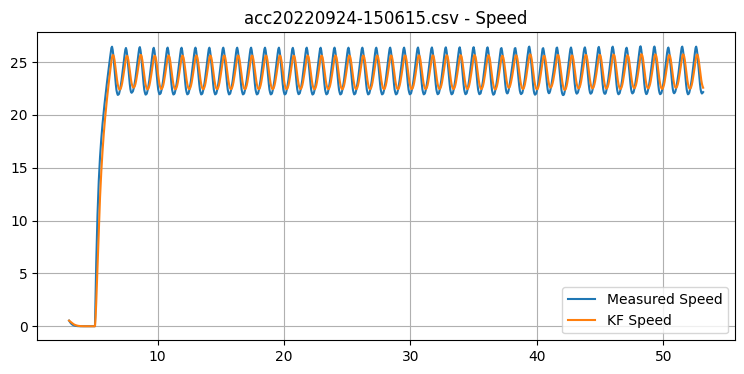

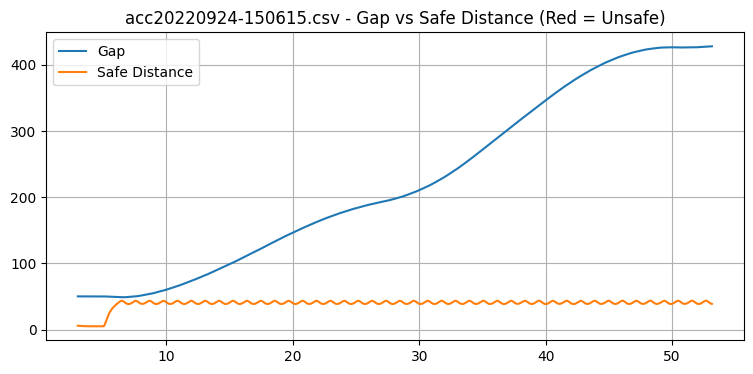


Processing: acc20220924-150805.csv
💾 Saved: acc20220924-150805_kf.csv


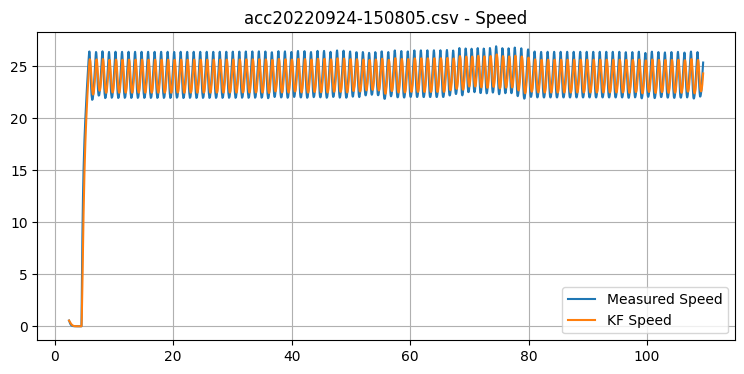

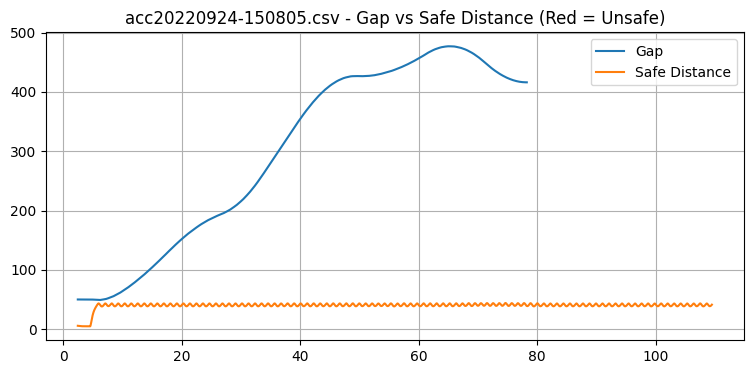


Processing: acc20220924-152419.csv
💾 Saved: acc20220924-152419_kf.csv


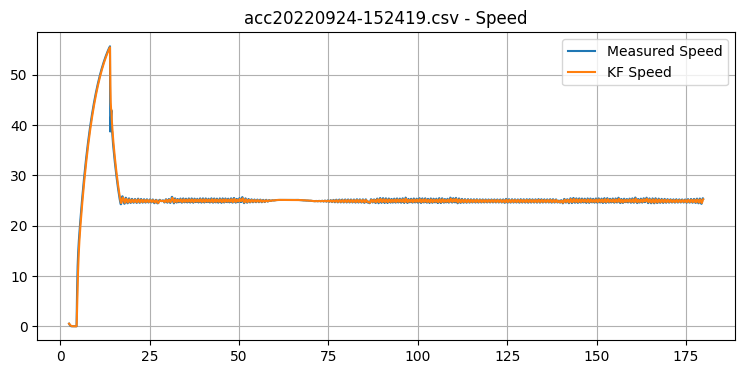

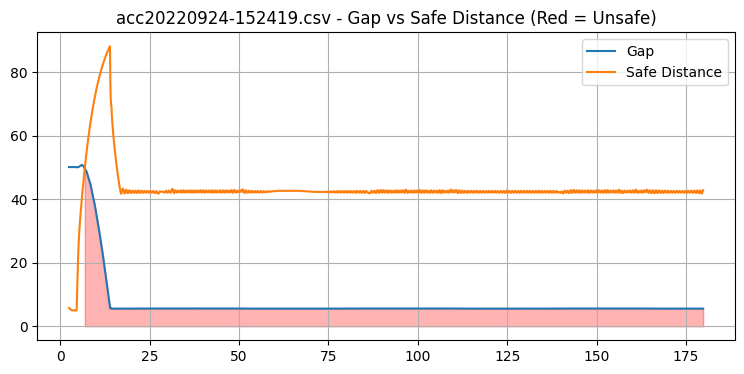


Processing: acc20220924-153153.csv
💾 Saved: acc20220924-153153_kf.csv


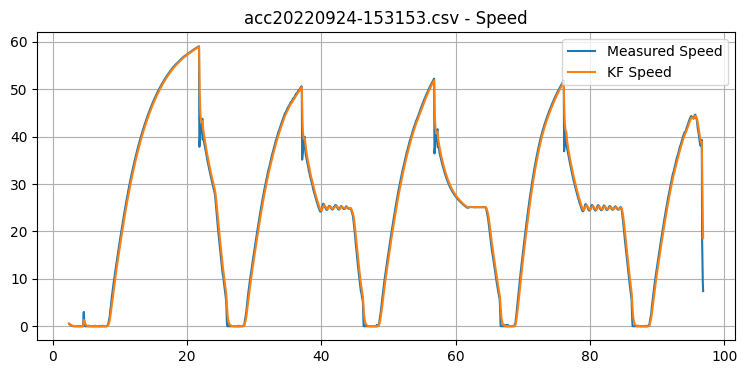

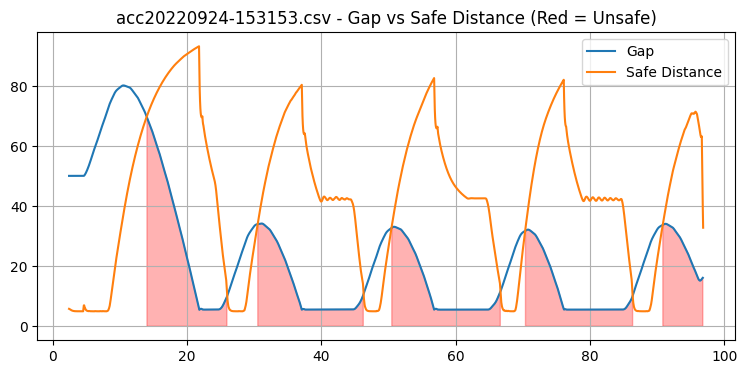


Processing: acc20220924-153650.csv
💾 Saved: acc20220924-153650_kf.csv


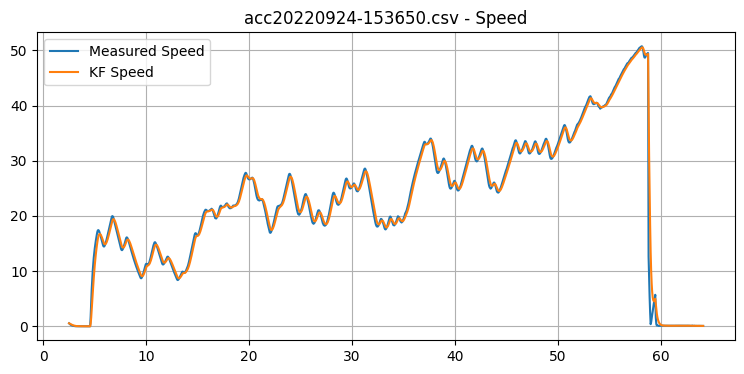

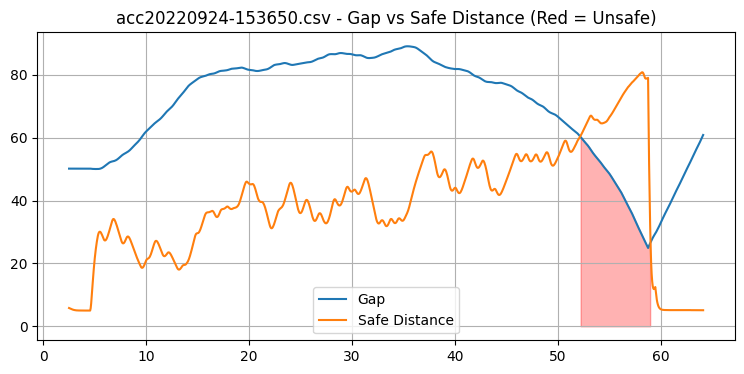


Processing: acc20220924-153831.csv
💾 Saved: acc20220924-153831_kf.csv


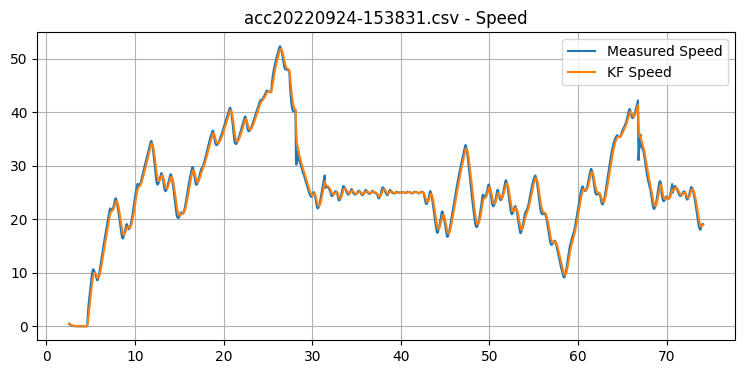

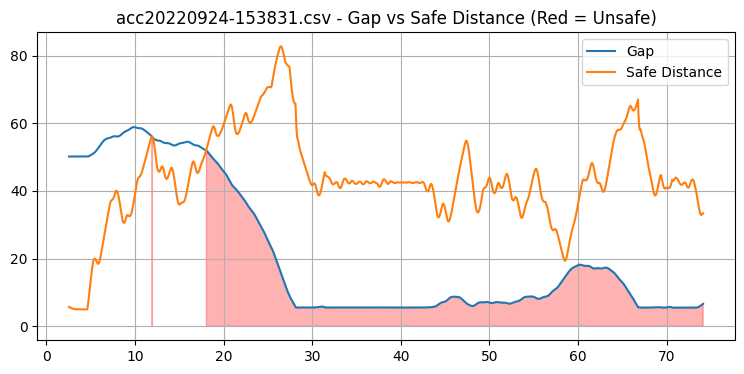


Processing: acc20220924-154355.csv
💾 Saved: acc20220924-154355_kf.csv


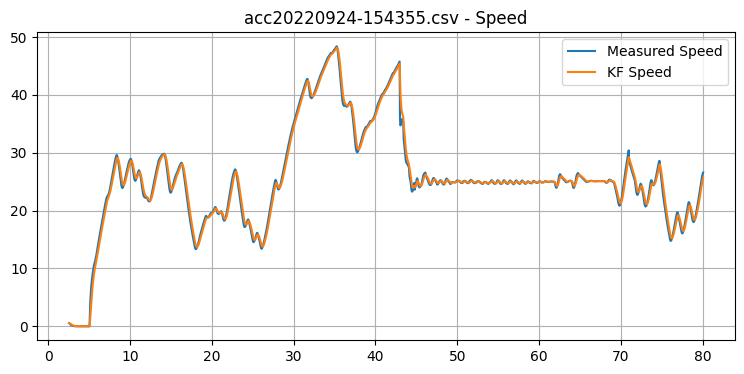

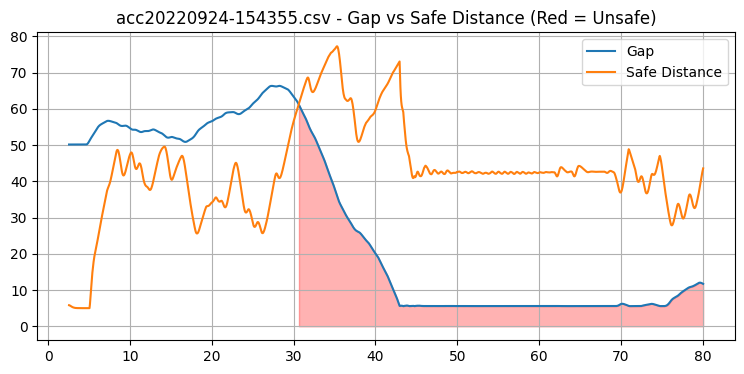

In [1]:
# ================================
# 1. Mount Google Drive
# ================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# ================================
# 2. Directory
# ================================
data_dir = "/content/drive/MyDrive/acc"
csv_files = sorted(glob.glob(os.path.join(data_dir, "acc*.csv")))

print("Found CSV files:")
for f in csv_files:
    print(" -", os.path.basename(f))

# ================================
# 3. Kalman Filter
# ================================
class KalmanFilter1D:
    def __init__(self, x0, P0, Q, R):
        self.x = x0
        self.P = P0
        self.Q = Q
        self.R = R

    def predict(self):
        self.P += self.Q

    def update(self, z):
        K = self.P / (self.P + self.R)
        self.x = self.x + K*(z - self.x)
        self.P = (1-K)*self.P
        return self.x

# ================================
# 4. Safety Parameters
# ================================
h = 1.5
d0 = 5.0

required_cols = [
    "timestamp",
    "ego_vehicle_x","ego_vehicle_y","ego_vehicle_z","ego_vehicle_v",
    "leader_vehicle_x","leader_vehicle_y","leader_vehicle_z","leader_vehicle_v"
]

# ================================
# 5. Process telemetry files only
# ================================
for csv_path in csv_files:
    print("\n====================================")
    print("Processing:", os.path.basename(csv_path))

    df = pd.read_csv(csv_path)

    # skip non-telemetry
    if not all(c in df.columns for c in required_cols):
        print("⚠️ Not telemetry, skipping…")
        continue

    # ---------- KF filtering ----------
    z = df["ego_vehicle_v"].values
    kf = KalmanFilter1D(z[0], 10, 0.01, 0.1)

    filtered = []
    for v in z:
        kf.predict()
        filtered.append(kf.update(v))
    df["ego_vehicle_v_kf"] = filtered

    # ---------- Gap ----------
    dx = df["ego_vehicle_x"] - df["leader_vehicle_x"]
    dy = df["ego_vehicle_y"] - df["leader_vehicle_y"]
    dz = df["ego_vehicle_z"] - df["leader_vehicle_z"]
    df["gap"] = np.sqrt(dx*dx + dy*dy + dz*dz)

    # ---------- Safe Distance ----------
    df["d_safe"] = h * df["ego_vehicle_v_kf"] + d0

    # ---------- IDS Trigger ----------
    df["IDS_trigger"] = df["gap"] < df["d_safe"]

    # ---------- Save ----------
    out_path = csv_path.replace(".csv", "_kf.csv")
    df.to_csv(out_path, index=False)
    print("💾 Saved:", os.path.basename(out_path))

    # ---------- Plot ----------
    plt.figure(figsize=(9,4))
    plt.plot(df["timestamp"], df["ego_vehicle_v"], label="Measured Speed")
    plt.plot(df["timestamp"], df["ego_vehicle_v_kf"], label="KF Speed")
    plt.title(os.path.basename(csv_path) + " - Speed")
    plt.grid(True); plt.legend(); plt.show()

    plt.figure(figsize=(9,4))
    plt.plot(df["timestamp"], df["gap"], label="Gap")
    plt.plot(df["timestamp"], df["d_safe"], label="Safe Distance")
    plt.fill_between(df["timestamp"], 0, df["gap"],
                     where=df["IDS_trigger"], color='red', alpha=0.3)
    plt.title(os.path.basename(csv_path) + " - Gap vs Safe Distance (Red = Unsafe)")
    plt.grid(True); plt.legend(); plt.show()
